# Access Control Effector - Compare Accounting Responses

In [1]:
library(ggplot2)
library(magrittr)
library(ggpubr)
library(repr)
library(reshape2)
library(nlme)

data_base <- "/data/reiner/jss-experiments/node1"
calculator_path <- "./calc-effector-response-time.sh"

redo <- FALSE

preprocess <- function(label, path) {
    if (file.exists(path)) {   
        response_file <- sprintf("%s/response-time.csv", path)

        print(sprintf ("Producing response times for %s at %s", label, path))
        response_time_calculator <- sprintf("%s %s", calculator_path, path)
        if (!file.exists(response_file) || redo) {
            system(response_time_calculator)
        }
        
        if (file.size(response_file) > 0) {    
            print(sprintf ("Reading %s %s", label, response_file))
            
            data <- read.csv(response_file, header=TRUE)
            
            data <- data[which(data$operation != 'public static org.iobserve.drive.accounting.Response org.iobserve.drive.accounting.HttpRequestUtils.get(java.net.URL)'),]

            base_time <- data[1,4]

            data[,4] <- (data[,4] - base_time)/1000/1000
            data[,3] <- data[,3]/1000/1000
          
            return(data.frame(data))
        } else {
            print(sprintf("%s file %s is empty.", label, response_file))
            return(0)
        }
    } else {
        print(sprintf("%s path %s is missing", label, path))
        return(0)
    }
}

sans_path <- sprintf("%s/accounting-sans/responses", data_base)
sans_data <- preprocess("Baseline", sans_path)

effector_data <- c()

effector_configuration_sizes <- c(1,10,100,1000,2000,3000,4000,5000,6000,7000,8000 ,9000,10000)

i <- 1
for (size in effector_configuration_sizes) {
    effector_path <- sprintf("%s/accounting/%d/responses", data_base,size)
    
    data <- preprocess("Effector", effector_path)
    
    effector_data[[i]] <- data.frame(data)
    
    i <- i + 1
}

[1] "Producing response times for Baseline at /data/reiner/jss-experiments/node1/accounting-sans/responses"
[1] "Reading Baseline /data/reiner/jss-experiments/node1/accounting-sans/responses/response-time.csv"
[1] "Producing response times for Effector at /data/reiner/jss-experiments/node1/accounting/1/responses"
[1] "Reading Effector /data/reiner/jss-experiments/node1/accounting/1/responses/response-time.csv"
[1] "Producing response times for Effector at /data/reiner/jss-experiments/node1/accounting/10/responses"
[1] "Reading Effector /data/reiner/jss-experiments/node1/accounting/10/responses/response-time.csv"
[1] "Producing response times for Effector at /data/reiner/jss-experiments/node1/accounting/100/responses"
[1] "Reading Effector /data/reiner/jss-experiments/node1/accounting/100/responses/response-time.csv"
[1] "Producing response times for Effector at /data/reiner/jss-experiments/node1/accounting/1000/responses"
[1] "Reading Effector /data/reiner/jss-experiments/node1/account

Throw away the first 1/4 of the data, as we need the steady state of the application.

In [2]:
n<-dim(sans_data)[1]
sans_data_steady <- sans_data[with(sans_data, order(time)),]
sans_data_steady <- data.frame(sans_data_steady[floor(n/4):n,])

effector_data_steady <- c()

for (i in 1:length(effector_configuration_sizes)) {
    data <- effector_data[[i]]
    if (is.data.frame(data)) {
        n<-dim(data)[1]
        data <- data[with(data, order(time)),]
        effector_data_steady[[i]] <- data.frame(data[floor(n/4):n,])
        print(is.data.frame(effector_data_steady[[i]]))
    } else {
        print(typeof(data))
        print(is.data.frame(data))
    }
}


[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE


In [3]:
for (i in 1:length(effector_configuration_sizes)) {
    d1 <- dim(effector_data_steady[[i]])[1]
    print(sprintf("Sizes %d - %d", i, d1))
}

[1] "Sizes 1 - 75001"
[1] "Sizes 2 - 75001"
[1] "Sizes 3 - 75001"
[1] "Sizes 4 - 75001"
[1] "Sizes 5 - 75001"
[1] "Sizes 6 - 75001"
[1] "Sizes 7 - 75001"
[1] "Sizes 8 - 75001"
[1] "Sizes 9 - 75001"
[1] "Sizes 10 - 75001"
[1] "Sizes 11 - 75001"
[1] "Sizes 12 - 75001"
[1] "Sizes 13 - 75001"


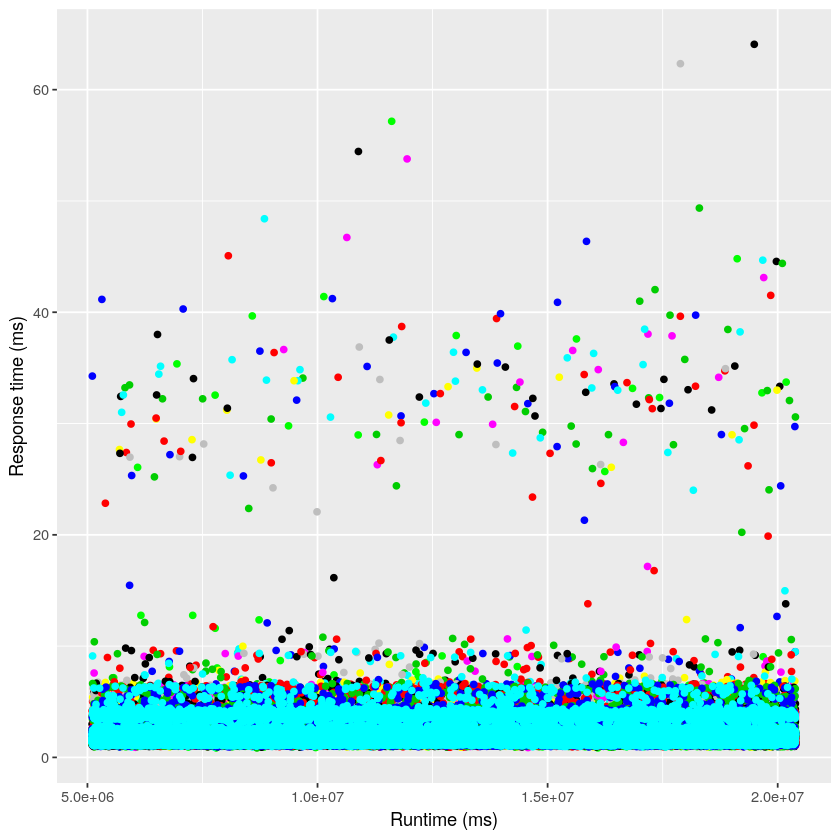

In [4]:
p <- ggplot(sans_data_steady, aes(time, response.time)) +
     geom_point(data = sans_data_steady, colour="green")

for (i in 1:length(effector_configuration_sizes)) {
     p <- p + geom_point(data=effector_data_steady[[i]], colour=i)
}


p <- p + 
    ylab("Response time (ms)") +
    xlab("Runtime (ms)")

p

Warning message:
“Removed 210003 rows containing non-finite values (stat_boxplot).”

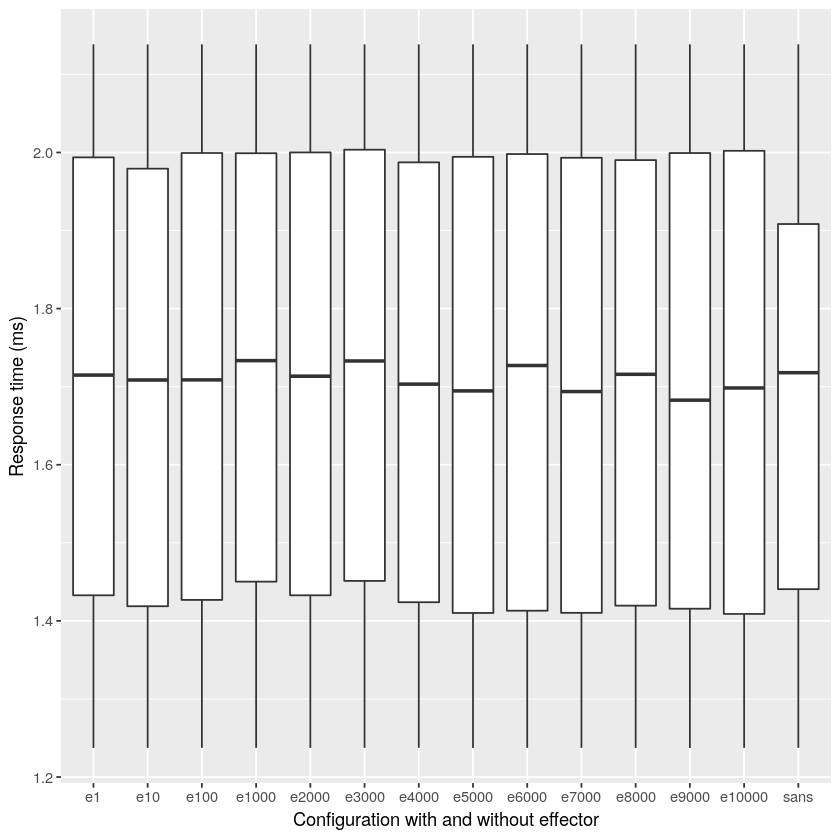

In [5]:
merged <- data.frame(
    e1=effector_data_steady[[1]]$response.time, 
    e10=effector_data_steady[[2]]$response.time, 
    e100=effector_data_steady[[3]]$response.time, 
    e1000=effector_data_steady[[4]]$response.time, 
    e2000=effector_data_steady[[5]]$response.time, 
    e3000=effector_data_steady[[6]]$response.time, 
    e4000=effector_data_steady[[7]]$response.time, 
    e5000=effector_data_steady[[8]]$response.time, 
    e6000=effector_data_steady[[9]]$response.time, 
    e7000=effector_data_steady[[10]]$response.time, 
    e8000=effector_data_steady[[11]]$response.time, 
    e9000=effector_data_steady[[12]]$response.time,
    e10000=effector_data_steady[[13]]$response.time,
    sans=sans_data_steady$response.time)

melted <- melt(merged, measure.vars=c("e1", "e10", "e100", "e1000", "e2000",
                                      "e3000", "e4000", "e5000", "e6000", "e7000",
                                      "e8000", "e9000", "e10000",
                                      "sans"))

ggplot(melted, aes(x=variable, value)) + 
    geom_boxplot(outlier.shape = NA) +
    scale_y_continuous(limits = quantile(melted$value, c(0.1, 0.9))) +
    ylab("Response time (ms)") +
    xlab("Configuration with and without effector")

[1] "Mean   1.691572 vs 1.779835  distance 0.088263 5.217794"
[1] "Q1     1.309276 vs 1.370890  distance 0.061614 4.705983"
[1] "Median 1.645044 vs 1.715044  distance 0.070000 4.255210"
[1] "Q3     1.910785 vs 2.022085  distance 0.111300 5.824811"


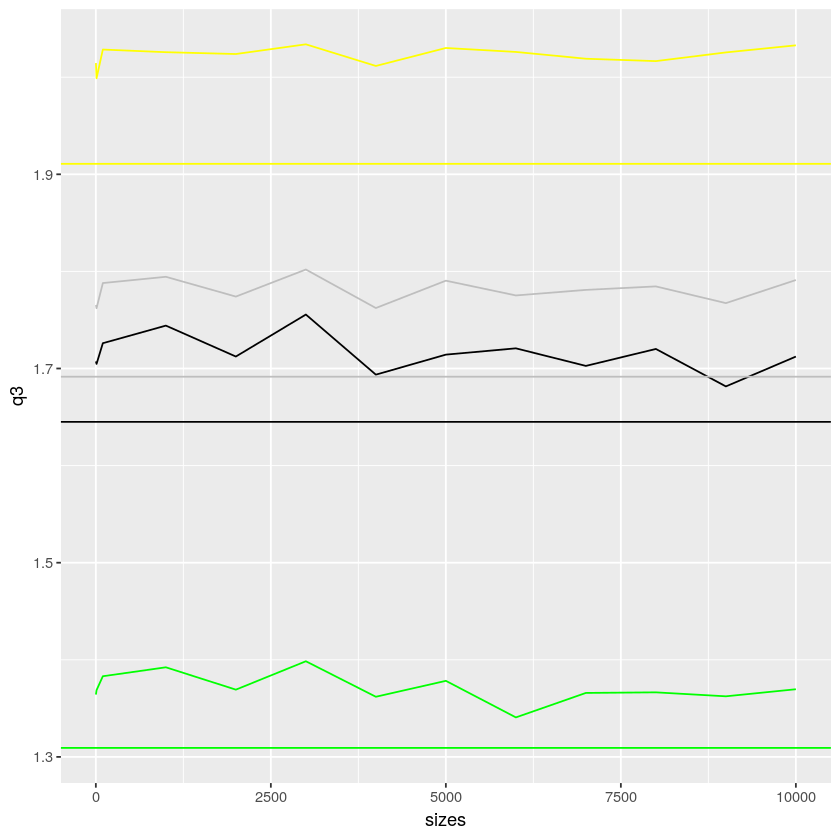

In [6]:
q1s <- c()
means <- c()
medians <- c()
q3s <- c()

for (i in c(1:length(effector_configuration_sizes))) {
    data <- effector_data_steady[[i]]
    if (is.data.frame(data)) {
        m <- mean(data$response.time)
        q <- quantile(data$response.time, c(0.25,0.5,0.75))
    } else {
        m <- 0.0
        q <- quantile(c(0,0,0), c(0.25,0.5,0.75))
    }
    
    means <- c(means,m)
    
    q1s <- c(q1s, q[1])
    medians <- c(medians, q[2])
    q3s <- c(q3s, q[3])
}

means.frame <- data.frame(sizes<-effector_configuration_sizes, means <- means, medians <- medians, q1 <- q1s, q3 <- q3s)


q <- quantile(sans_data_steady$response.time, c(0.25,0.5,0.75))
m <- mean(sans_data_steady$response.time)

ggplot(means.frame, aes(sizes , q3)) + 
    geom_line(aes(sizes,means), colour="gray") + 
    geom_line(aes(sizes, q1), colour="green") + 
    geom_line(aes(sizes,medians)) + 
    geom_line(aes(sizes,q3), colour="yellow") +
    geom_hline(yintercept = q[1], colour="green") +
    geom_hline(yintercept = q[2]) +
    geom_hline(yintercept = q[3], colour="yellow") +
    geom_hline(yintercept = m, colour="gray")

eq1 <- mean(means.frame$q1)
emedian <- mean(means.frame$medians)
eq3 <- mean(means.frame$q3)
emean <- mean(means.frame$means)

print(sprintf("Mean   %f vs %f  distance %f %f", m, emean, emean-m, 100/m*(emean-m)))
print(sprintf("Q1     %f vs %f  distance %f %f", q[1], eq1, eq1 - q[1], 100/q[1]*(eq1 - q[1])))
print(sprintf("Median %f vs %f  distance %f %f", q[2], emedian, emedian - q[2], 100/q[2]*(emedian - q[2])))
print(sprintf("Q3     %f vs %f  distance %f %f", q[3], eq3, eq3 - q[3], 100/q[3]*(eq3 - q[3])))



Warning message:
“Removed 52501 rows containing non-finite values (stat_ydensity).”

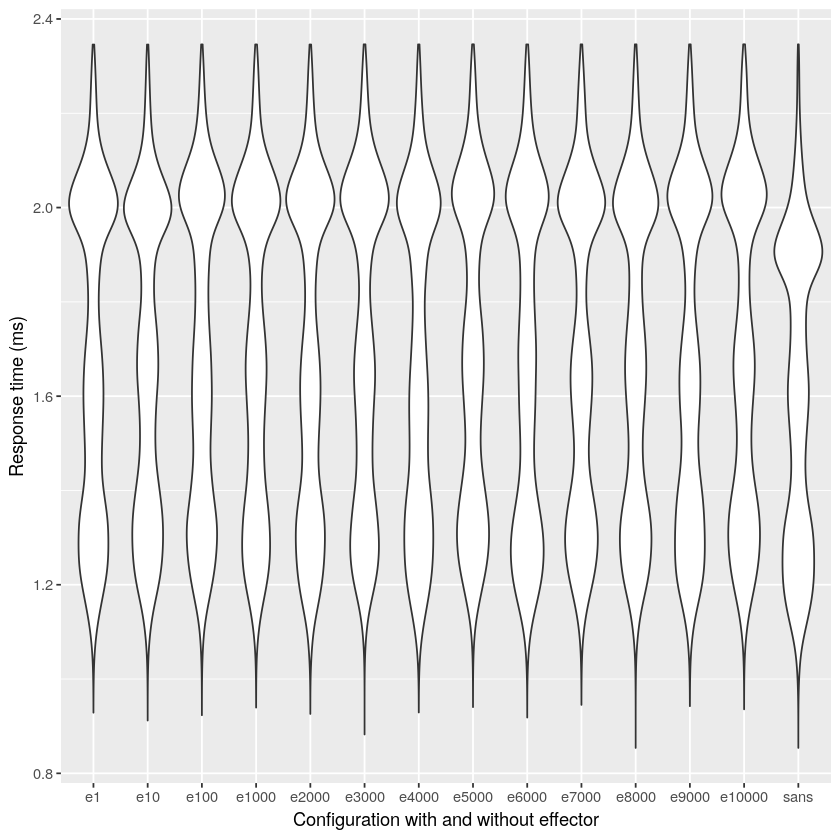

In [7]:
ggplot(melted, aes(x=variable, value)) + 
    geom_violin() +
    scale_y_continuous(limits = quantile(melted$value, c(0, 0.95))) +
    ylab("Response time (ms)") +
    xlab("Configuration with and without effector")